In [1]:
%config Completer.use_jedi = False

# Introduction to Artificial Neural Networks with Keras

*Artificial Nerual Networks* (ANNs) are Machine Learning models inspired by the networks of biological neurons found in our brains.  ANNs are at the very core of Deep Learning. They are versatile, powerful, and scalable, making them ideal to tackle large and highly complex Machine Learning tasks such as classifying billions of images, powering speech recognition services, recommending the best videos to watch to hundreds of millions of users every day, or learning to beat the world champion at a game of Go.

The first part of this chapter introduces artificial neural networks.  In the second part, we will look at how to implement neural networks using the popular Keras API.

## From Biological to Artificial Neurons

The early successes of ANNs led to widespread belief that we would soon be conversing with truly intelligent machines.  When it became clear in the 1960's that this promise would go unfulfilled, funding flew elsewhere, and ANNs entered a long winter.  In the early 1980s, new architectures were invented and better training techniques were developed, sparking a revival of interest in *cnnectionism* (the study of neural networks).  But progress was slow, and by the 1990s other powerful Machine Learning techniques were invented, such as Support Vector Machines.  These techniques seemed to offer better results and stronger theoretical foundations than ANNs, so once again the study of neural networks was put on hold.

We are now witnessing yet another wave of interest in ANNs, and this time is different.
* There are now a huge quantity of data available to train neural networks, and ANNs frequently outperform other ML techniques on very large and complex problems.
* The tremendous increase in computing power since the 1990s now makes it possible to train large neural networks in a reasonable amount of time.
* The training algorithms have been improved.
* ANNs seem to have entered a virtuous cirle of funding and progress.

## The Perceptron

The *Perceptron* is one of the simplest ANN architectures, invented in 1957 by Frank Rosenblatt.  It is based on a *threshold logic unit* (TLU). For a TLU, the inputs and outputs are numbers, and each input connection is associated with a weight.  The TLU computes a weighted sum of its inputs, then applies a *step function* to that sum and outputs the results.

A Perceptron is simply composed of a single layer of TLUs, with each TLU connected to all the inputs.  When all the neurons in a layer are connected to every neuron in the previous layer, the layer is called a *fully connected layer*, or a *dense layer*.

Thanks to the magic of linear algebra, Equation 10-2 makes it possible to efficiently compute the outputs of a layer of artificial neurons for several instances at once.

<c> Equation 10-2: Computing the outputs of a fully connected layer </c>
$$ h_{W, b}(X) = \phi(XW + b) $$

So how is a Perceptron trained? "Cells that fire together, wire together." Perceptrons are trained using a variant of this rule that takes into account the error made by the network when it makes a prediction; the Perceptron learning rule reinforces connections that help reduce the error.  More specifically, the Perceptron is fed one training instance at a time, and for each instance it makes its predictions.  For every output neuron that produced a wrong prediction, it reinforces the connection weights from the inputs that would ahve contributed to the correct prediction.  

**The decision boundary of each output neuron is linear, so Perceptrons are incapable of learning complex patterns (just like Logistic Regression classifiers).**

Scikit-Learn provides a Perceptron class that implements a single-TLU network.

#### Example 1: Scikit-Learns Perceptron

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(int) # Iris Setosa

per_clf = Perceptron()
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([0])

You may have noticed that the Perceptron learning algorithm strongly resembles Stochastic Gradient Descent.  In fact, Scikit-Learn's Perceptron class is equivalent to using an SGDClassifier with the following hyperparameters: loss = 'perceptron', learning_rate = 'constant', eta0 = 1 (the learning rate), and penalty = None (no regularization).

Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class probability.  This is one reason to prefer Logistic Regression over Perceptrons.

There are a number of significant weaknesses of Perceptrons, in particular that they are incapable of solving some trivial problems.  It turns out that some of the limitations of Perceptrons an be eliminated by stacking multiple Perceptrons.  The resulting ANN is called a *Multilayer Perceptron* (MLP)

## The Multilayer Perceptron and Backpropagation

An MLP is composed of one (passthrough) *input layer*, one or more layers of TLUs, called *hidden layers*, and one final layer of TLUs, called the *output layer*.  The layers close to the input layers are usually called the *lower layers* and the ones close to the outputs are usually called the *upper layers*.  Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

The signal flows only in one direction (from the inputs to the oupts), so this architecture is an example of a *feedforward neural network* (FNN).

When an ANN contains a deep stack of hidden layers (dozens or hundreds), it is called a *deep neural network* (DNN).  For many years researchers struggled to find a way to train MLPs, without success, until 1986 when David Rumelhart, Geoffrey Hinton, and Ronald Williams published a groundbreaking paper that introduced the *backpropagation* training algorithm, which is still used today.

In short, it is Gradient Descent using an efficient technique for computing the gradients automatically: in just two passes through the network (one forward, one backward), the backpropagation algorithm is able to compute the gradient of the network's error with regard to every single model parameter.  In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error.  Once it has these gradients, it just performs a regular Gradient Descent step, and the whole process is repeated until the network converges to the solution.

Automatically computing gradients is called *automatic differentiation* or *autodiff*.  There are various autodiff techniques, with different pros and cons.  The one used by backpropagation is called *reverse-moode autodiff*.  It is fase and precise, and is well suited when the function to differentiate has many variables and few outputs.

Let's run through the algorithm in a bit more detail:
* It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times.  Each pass is called an *epoch*
* Each mini-batch is passed to the network's input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. This is the *forward pass*: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.
* Next, the algorithm measures the network's output error (i.e. it uses a loss function that compares the desired output and the actual output of the network, and returns some measure of the error).
* Then it computes how much each output connection contributed to the error. This is done analytically by applying the *chain rule* (perhaps the most fundamental rule in calculus), which makes this step fast and precise.
* The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until the algorithm reaches the input layer.  As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network.
* Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

**This algorithm is so important that it's worth summarizing it again: for each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally tweaks the connection weights to reduce the error (Gradient Descent step)**

***It is important to initialize all the hidden layers' connection weights randomly, or else training will fail.***

In order for this algorithm to work properly, its authors made a key change to the MLP's architecture: they replaced the step function with the logistic (sigmoid) function:
$$ \sigma(z) = \frac{1}{1 + \exp(-z)} $$

The backpropagation algorithm works well with many other activation functions.  Here are two other popular choices:
1. **The hyperbolic tanger function: tanh(z)**: $2\sigma(2z) - 1$
<br>Just like the logistic function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from -1 to 1 (instead of 0 to 1 in the case of the logistic function). That range tends to make each layer's output more or less centered around 0 at the beginning of training, which often helps speed up convergence.
2. **The Rectified Linear Unit function: ReLU(z)**: $max(0, z)$
<br>The ReLU function is continuous but unfortunatley not differentiable at z=0 (the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is 0 for z < 0. In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. Most importantly, the fact that it does not have a maximum output value helps reduce some issues during Gradient Descent.

Why do we need activation functions in the first place? Well, if you chain several linear transformations, all you get is a linear transformation. So if you don't have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can't solve very complex problems with that. Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.

## Regression MLPs

First, MLPs can be used for regression tasks. If you want to predict a single value (like the value of a house), then you just need a single output neuron: its output is the predicted value. For multivariate regression (predicting multiple values at once), you need one output neuron per output dimension. For example, to locate the center of an object in an image, you need to predict 2D cooridinates, so you need two output neurons.

**In general, when building an MLP for regression, you do not want to use any activation function for the output neurons, so they are free to output any range of values.** If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer. Alternatively, you can use the *softplus* activation function, which is a smooth variant of ReLU: $softplus(z) = log(1 + \exp(z))$

The loss function to use during training is typically the mean squared error, but if you have a lot of outliers in the training set, you may prefer to use the mean absolute error instead. Alternatively, you can us ethe Huber loss, which is a combination of both.

The Huber loss is quadratic when the error is smaller than a threshold $\delta$ (typically 1) but linear when the error is larger than $\delta$. The linear part makes it less sensitive to outliers than the mean squared error, and the quadratic part allows it to converge faster and be more precise than the mean absolute error.

In [15]:
import pandas as pd

# Typical regression MLP architecture
pd.DataFrame.from_dict(data={
    'Input Neurons': 'One per intput feature',
    'Hidden Layers': 'Depends on the problem, typically 1 to 5',
    'Neurons per Layer': 'Depends on the problem, typically 10 to 100',
    'Output Neurons': '1 per prediction dimension',
    'Hidden Activation': 'ReLU or SELU',
    'Output Activation': 'None, or ReLU/softplus. Generally tailored for desired output.',
    'Loss Function': 'MSE, MAE or Huber if outliers'
}, orient='index').rename(columns={0: 'Typical Value'})

,Typical Value
Input Neurons,One per intput feature
Hidden Layers,"Depends on the problem, typically 1 to 5"
Neurons per Layer,"Depends on the problem, typically 10 to 100"
Output Neurons,1 per prediction dimension
Hidden Activation,ReLU or SELU
Output Activation,"None, or ReLU/softplus. Generally tailored for..."
Loss Function,"MSE, MAE or Huber if outliers"


## Classification MLPs

MLPs can also be used for classification tasks. For a binary classification problem, you just need a single output neuron using the logistic activation function: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class.

MLPs can also easily handle multilabel binary classification tasks. More generally, you would dedicate one output neuron for each positive class. Note that the output probabilities do no necessarily add up to 1.

If each instance can belong only to a single class, out of three or more possible classes (e.g. classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activiation function for the whole output layer. The softmax function will ensure that all the estimated probabilities are between 0 and 1 and they they add up to 1 (which is required if the classses are exclusive). This is called multiclass classification.

Regarding the loss function, since we are predicting probability distributions, the cross-entropy loss (also called the log loss) is generally a good choice.

In [18]:
# Typical classification MLP architecture
pd.DataFrame.from_dict({
    'Input and Hidden Layers': ['Same as regression', 'Same as regression', 'Same as regression'],
    'Number of Output Neurons': ['1', '1 per label', '1 per class'],
    'Output Layer Activation': ['Logistic', 'Logistic', 'Softmax'],
    'Loss Function': ['Cross-Entropy', 'Cross-Entropy', 'Cross-Entropy']
}, orient='index').rename(columns={0: 'Binary Classification', 1: 'Multilabel Binary Classification', 2: 'Multiclass Classification'})

,Binary Classification,Multilabel Binary Classification,Multiclass Classification
Input and Hidden Layers,Same as regression,Same as regression,Same as regression
Number of Output Neurons,1,1 per label,1 per class
Output Layer Activation,Logistic,Logistic,Softmax
Loss Function,Cross-Entropy,Cross-Entropy,Cross-Entropy


## Implementing MLPs with Keras

At present, you can choose from 3 popular open source Deep Learning libraries:
1. TensorFlow
2. Microsoft Cognitive Toolkit
3. Theano

As of 2016 Keras can be run on:
1. Apache MXNet
2. Apple's Core ML
3. JavaScript
4. TypeScript
5. PlaidML

Moreover, TensorFlow itself now comes bundled with its own Keras implementation, tf.keras. It only supports TensorFlow as the backend, but it has the advantage of offering some very useful extra features like TensorFlow's Data API which makes it easy to load and preprocess data efficiently.

**The most populare Deep Learning library after Keras and TensorFlow is Facebook's PyTorch. The good news is that its API is quite similar to Keras's, so once you know Keras, it is not difficult to switch to PyTorch, if you ever want to.** PyTorch's popularity grew exponentially in 2018, largely thanks to its simplicity and excellent documenatation, which were not TensorFlow 1.x's main strengths. However, TensorFlow 2 is arguably just as simple as PyTorch, as it has adopted Keras as its official high-level API and its developers have greatly simplified and cleaned up the rest of the API. Similarly, PyTorch's main weaknesses (e.g. limited portability and on computation graph analysis) have been largely addressed in PyTorch 1.0. Healthy competition is beneficial to everyone!

## Installing TensorFlow 2

In [22]:
# pip install -U tensorflow

In [23]:
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.8.0', '2.8.0')

For GPU support, at the time of this writing you need to install tensorflow-gpu instead of tensorflow, but the TensorFlow team is working on having a single library that will support both CPU-only and GPU-equipped systems. You will need to install extra libraries for GPU support (see http://tensorflow.org/install for more details).

## Building an Image Classifier Using the Sequential API

### Using Keras to load the dataset

In [27]:
# Load the Keras dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Check dimensions and datatypes
print(X_train_full.shape, X_train_full.dtype)

# Split the training set into a validation and training set
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
class_names[y_train[0]]

(60000, 28, 28) uint8


'Coat'

### Creating the model using the Sequential API

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1,149,010
Trainable params: 1,149,010
Non-

Let's go through this code line by line:
1. The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the Sequential API.
2. Next, we build the first layer and add it to the model. It is a Flatten layer whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters; it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the input_shape, which doesn't include the batch size, only the shape of the instances. Alternatively, you could add a keras.Layers.InputLayer as the first layer, setting input_shape=[28, 28].
3. Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activiation function. **Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs.** It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes Equation 10-2.
4. The we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
5. Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive.)

**Note that Dense layers often have a *lot* of parameters. This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data**

You can easily get a model's list of layers, to fetch a layer by its index, or you can fetch it by name. All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. For a Dense layer, this includes both the connection weights and the bias terms.

In [32]:
model.layers, model.layers[1].name, model.get_layer(model.layers[1].name) is model.layers[1]

([<keras.layers.core.flatten.Flatten at 0x1ce86533fd0>,
 'dense',
 True)

In [33]:
weights, biases = model.layers[1].get_weights()
weights.shape, biases.shape, weights

((784, 500),
 (500,),
 array([[-0.03359945,  0.04327252, -0.00304671, ..., -0.02342163,
          0.02088782, -0.0463709 ],
        [ 0.05201065, -0.01721509, -0.06608457, ...,  0.01044047,
         -0.01129175,  0.0500773 ],
        [ 0.02180307, -0.03091266,  0.06639855, ..., -0.05205602,
          0.04430411,  0.05435304],
        ...,
        [ 0.05639988,  0.06735679, -0.00417599, ..., -0.0202131 ,
          0.03268155,  0.06603561],
        [-0.03783273, -0.01314694,  0.0018714 , ...,  0.00512154,
          0.04910091, -0.06526025],
        [-0.06391209, -0.02634633,  0.02139831, ..., -0.02582237,
          0.03113466, -0.04264457]], dtype=float32))

The shape of the weight matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. **Until the model is really built, the layers will not have any weights, and you will not be able to do certain things such as print the model summary or save the model.** So if you know the input shape when creating the model, it is best to specify it.

### Compiling the model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation.

In [37]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

This code requires some explanation. **First, we use the 'sparse_categorical_crossentropy' loss because we have sparse labels (i.e. for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0, 0, 1, 0]) to represent class 2), then we would need to use the 'categorical_crossentropy' loss instead.**

If we were doing binary classification (with one or more binary labels), then we would use the 'sigmoid' (i.e. logistic) activiation function in the output layer instead of the 'softmax' activiation function, and we would use the 'binary_crossentropy' loss.

If you want to convert sparse labels (i.e. class indices) to one-hot vector labels, use the keras.utils.to_categorical() function. To go the other way around, use the np.argmax() function with axis=1.

When using the SGD optimizer, it is important to tune the learning rate. So, you will generally want to use optimizer=keras.optimizers.SGD(learning_rate=???) to set the learning rate, rather than optimizer='sgd', which defaults to learning_rate=0.01

### Training and evaluating the model

Now the model is ready to be trained. For this we simply need to call its fit() method. We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train. We also pass a validation set (this is optional). Keras will measure the loss and the extra metrics on this set at the end of each epoch. If the performance on the training set is much better than the validation set, your model is probably overfitting the training set (or there is a bug such as a data mismatch between the training set and the validation set).

Instead of passing a validation set using the validation_data argument, you could set validation_split to the ratio of the training set that you want Keras to use for validation. For example, validation_split=0.1 tells Keras to use the last 10% of the data (before shuffling) for validation.

**If the training set was very skewed, with some classes being overrepresented and others underrepresnted, it would be useful to set the class_weight argument when calling the fit() method, which would give a larger weight to underrepresented classes and a lower weight to overrepresented classes.**

If you need per-instance weights, set the sample_weight argument (it supersedes class_weight). Per-instance weights could be useful if some instances were labeled by experts while others were labelled using a crowdsourcing platform: you might want to give more weight to the former.

The fit() method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you use this dictionary to create a pandas DataFrame and call its plot() method, you get the learning curves for the model.

**If your training or validation data does not match the expected shape, you will get an exception. This is perhaps the most common error, so you should get familiar with the error message. The message is actually quite clear: for example, if you try to train this model with an array containing flattened images it will throw this error.**

If the validation curves are close to the training curves, it means there is not too much overfitting. In this particular case, the model looks like it performed better on the validation set than on the training set at the beginning of training. But that's not the case: indeed, the validation error is computed at the *end* of each epoch, while the training error is computed using a running mean *during* each epoch. So the training curve should be shifted by half an epoch to the left. If you do that, you will see the that the training and validations curve overlap almost perfectly at the beginning of training.

**When plotting the training curve, it should be shifted by half an epoch to the left.**

In [41]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid)
)

Epoch 1/30
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7140 - accuracy: 0.7595 - val_loss: 0.5326 - val_accuracy: 0.8062
Epoch 2/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4629 - accuracy: 0.8363 - val_loss: 0.4493 - val_accuracy: 0.8424
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4118 - accuracy: 0.8523 - val_loss: 0.3763 - val_accuracy: 0.8738
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3785 - accuracy: 0.8638 - val_loss: 0.3627 - val_accuracy: 0.8714
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3564 - accuracy: 0.8710 - val_loss: 0.3488 - val_accuracy: 0.8764
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3385 - accuracy: 0.8778 - val_loss: 0.3499 - val_accuracy: 0.8742
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3231 - accuracy: 0.8830 - val_loss: 0.3280 - val_accuracy

<Axes: >

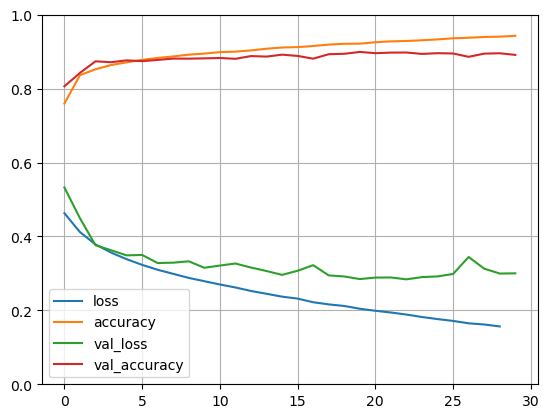

In [42]:
# Create DataFrame from model history
learning_curves = pd.DataFrame.from_dict(history.history, orient='columns')

# Shift training loss back by 1 epoch for betting alignment (this is shifted left by 0.5 epochs becuase the training loss is a rolling mean during the epoch)
learning_curves.loc[:, 'loss'] = learning_curves.loc[:, 'loss'].shift(-1)

# Plot
learning_curves.plot(ylim=(0,1), grid=True)

The training set performance ends up beating the validation performance, as is generally the case when you train for long enough. **You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue trianing.** It's as simple as calling the fit() method again, since Keras just continues training where you left off.

If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. The first one to check is the learning rate. If that doesn't help, try another optimizer (and always return the learning rate after changing any hyperparameter). If the performance is still not great, then try tuning the model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer. You can also try tuning other hyperparameters, such as the batch size.  

Once you are satisfied with your model's validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this by using the evaluate() method. It is common to get slightly lower performance on the test set than the validation set, because the hyperparameters are tuned on the validation set, not the test set.

In [44]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 48.8082 - accuracy: 0.8611


[48.80824661254883, 0.8611000180244446]

### Using the model to make predictions

Next, we can use the model's predict() method to make predictions on new instances. If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the predict_classes() method instead.

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [48]:
y_pred = np.argmax(y_proba, axis=1)
y_pred, np.array(class_names)[y_pred], y_test[:3]

(array([9, 2, 1], dtype=int64),
 array(['Ankle Boot', 'Pullover', 'Trouser'], dtype='<U11'),
 array([9, 2, 1], dtype=uint8))

## Building a Regression MLP Using the Sequential API

In [50]:
' Lets switch to the California housing problem and tackle it using a regression neural network'
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the raw data
housing = fetch_california_housing()

# Split data in train, val and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data,
    housing.target
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y_train_full
)

# Scale the data. Remember, only fit the scaler to the train data.  Transform the val and test data according to this fit.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Construct the TF model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.SGD(learning_rate=0.01)
)
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid)
)

# Evaluate performance on the test set
mse_test = model.evaluate(X_test, y_test)

# Make predictions
X_new = X_test[:3] # Pretend these are new instances
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8711 - val_loss: 0.6582
Epoch 2/20
363/363 [==============================] - 0s 991us/step - loss: 0.7041 - val_loss: 5.2731
Epoch 3/20
363/363 [==============================] - 0s 972us/step - loss: 0.8312 - val_loss: 1.6523
Epoch 4/20
363/363 [==============================] - 0s 999us/step - loss: 2.1917 - val_loss: 0.4314
Epoch 5/20
363/363 [==============================] - 0s 978us/step - loss: 0.4072 - val_loss: 0.3994
Epoch 6/20
363/363 [==============================] - 0s 999us/step - loss: 0.3887 - val_loss: 0.3837
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3808 - val_loss: 0.3785
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3755 - val_loss: 0.3794
Epoch 9/20
363/363 [==============================] - 0s 995us/step - loss: 0.3724 - val_loss: 0.3769
Epoch 10/20
363/363 [==============================] - 0s 991us/step - loss: 0.3686 - va

In [51]:
mse_test, y_pred, y_test[:3]

(0.34543487429618835,
 array([[1.2096193],
        [1.5039266],
        [1.9677328]], dtype=float32),
 array([1.208, 1.33 , 0.8  ]))

In [52]:
scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 7))), axis=1))[:, 0] * 1e5

array([617464.30677533, 673506.12120398, 761823.78714835])

In [53]:
scaler.inverse_transform(np.concatenate((y_test[:3].reshape(-1, 1), np.zeros((y_test[:3].shape[0], 7))), axis=1))[:, 0] * 1e5

array([617155.96383064, 640387.12450146, 539464.86912822])

## Building Complex Models Using the Functional API

One example of a nonsequential neural network is a *Wide & Deep* neural network. It connects all or part of the inputs directly to the output layer. **This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path).** In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by the sequence of transformations. Let's build such a neural network to tackle the California housing problem.

In [56]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

Let's go through each line of this code:
1. First, we need to create an Input object. This is a specification of the kind of input the model will get, including its shape and dtype. A model may actually have multiple inputs, as we will see shortly.
2. Next, we create a Dense layer with 30 neurons, using the ReLU activation function. **As soon as it is created, notice that we call it like a function, passing it the input.** This is why this is called the Functional API. **Note that we are just telling Keras how it should connect the layers together**, no actual data is being processed yet. 
3. We then create a second hidden layer, and again we use it as a function. **Note that we pass it the output of the first hidden layer.**
4. Next, we create a Concatenate layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer. You may prefer the keras.layers.concatenate() function, which creates a Concatenate layer and immeidately calls it with the given inputs.
5. Then we create the output layer, with a single neuron and no activiation function, and we call it like a function, passing it the result of the concatenation.
6. Lastly, we create a Keras Model, specifying which inputs and outputs to use.

But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path? In this case, one solution is to use multiple inputs. In this case, when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_A, X_train_B): one per input. Alternatively, you can pass a dictionary mapping the input names to the input values, like {'wide_input': X_train_A, 'deep_input': X_train_B}. This is especially useful when there are many inputs, to avoid getting the order wrong.

In [58]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(learning_rate=1e-3)
)

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(
    (X_train_A, X_train_B),
    y_train,
    epochs=20,
    validation_data=((X_valid_A, X_valid_B), y_valid)
)

mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

mse_test, y_pred

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.2701 - val_loss: 0.9575
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8566 - val_loss: 0.7429
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6925 - val_loss: 0.6331
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6369 - val_loss: 0.6037
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.5838
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5930 - val_loss: 0.5686
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5766 - val_loss: 0.5541
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5631 - val_loss: 0.5424
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5504 - val_loss: 0.5331
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5404 - val_loss: 0.5231

(0.4914042055606842,
 array([[1.0061936],
        [1.754076 ],
        [1.0933515]], dtype=float32))

There are many use cases in which you may want to have multiple outputs:
1. The task may demand it. For instance, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
2. Similarly, you may have multiple independent tasks based on the same data. **Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are usefull across tasks.** For example, you could perform *multitask classification* on pictures of faces, using one output to classify the person's facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not.
3. Another use case is as a regularization technique (i.e. a training contraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture to ensure that hte underlying part of the newtwork learns something useful on its own, without relying on the rest of the network.

Adding extra outputs is quite easy: just connect them to the appropriate layers and add them to your model's list of outputs. Each output will need its own loss function. Therefore, when we compile the model, we should pass a list of losses. By default, Keras will compute all these losses and simply add them up to get the final loss used for training. We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output's loss a much greater weight. Fortunately, it is possible to set all the loss weights when compiling the model. Also, now when we train the model, we need to provide labels for each output.

When we evaluate the model, Keras will return the total loss, as well as the individual losses. Similarly, the predict() method will return predictions for each output.

In [60]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B],
    [y_test, y_test]
)

y_pred_main, y_pred_aux = model.predict(
    [X_test_A[:3], X_test_B[:3]]
)

total_loss, main_loss, aux_loss, y_pred_main, y_pred_aux

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9058 - main_output_loss: 0.8540 - aux_output_loss: 1.3723 - val_loss: 0.7514 - val_main_output_loss: 0.7266 - val_aux_output_loss: 0.9750
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 1.1638 - main_output_loss: 1.1771 - aux_output_loss: 1.0438 - val_loss: 0.5052 - val_main_output_loss: 0.4539 - val_aux_output_loss: 0.9671
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4844 - main_output_loss: 0.4432 - aux_output_loss: 0.8548 - val_loss: 0.5951 - val_main_output_loss: 0.5688 - val_aux_output_loss: 0.8314
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4936 - main_output_loss: 0.4626 - aux_output_loss: 0.7730 - val_loss: 0.5773 - val_main_output_loss: 0.5623 - val_aux_output_loss: 0.7115
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5510 - main_output_loss: 0.5304 - aux_output_loss: 0.7357 - val_loss

(0.3485252559185028,
 0.33540692925453186,
 0.46659132838249207,
 array([[1.2118365],
        [1.3224323],
        [1.3681982]], dtype=float32),
 array([[0.88918924],
        [1.0992093 ],
        [1.87235   ]], dtype=float32))

## Using the Subclassing API to Build Dynamic Models

Both the Sequential API and the Functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. This has many advantages:
1. The model can easily be saved, cloned and shared
2. Its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early.
3. It's fairly easy to debug, since the whole model is a static graph of layers.

But the flip side is just that: it's static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.

Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the Functional API. The big difference is that you can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations, etc. This makes it a great API for researchers experimenting with new ideas.

This extra flexibility does come at a cost: your model's architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. **So unless you really need that extra flexibility, you should probably stick to the Sequential and Functional API.**

In [63]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g, name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs: tuple):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel()

## Saving and Restoring a Model

Saving a trained Keras model is as simple as it gets. Keras will use the HDF5 format to save both the model's architecture (including every layer's hyperparameters) and the values of all the model parameters for every layer (e.g. connection weights and biases).. It also saves the optimizer (including its hyperparameters and any state it may have). Loading the model is just as easy.

**This will work when using the Sequential API and Functional API, but unfortunately not when using model subclassing. You can use save_weights() and load_weights() to at least save and restore the model parameters, but you will need to save and restore everything else yourself**

But what if training lasts several hours? This is quite common, especially when training on large datasets. In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during the training, to avoid losing everything if your computer crashes. But how can you tell the fit() method to save checkpoints? **Use callbacks**

In [66]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

model.save('my_keras_model.h5')
loaded_model = keras.models.load_model('my_keras_model.h5')

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2706 - main_output_loss: 1.2238 - aux_output_loss: 1.6922 - val_loss: 2.6055 - val_main_output_loss: 2.7245 - val_aux_output_loss: 1.5337
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7850 - main_output_loss: 0.7477 - aux_output_loss: 1.1211 - val_loss: 0.5283 - val_main_output_loss: 0.4829 - val_aux_output_loss: 0.9367
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4986 - main_output_loss: 0.4589 - aux_output_loss: 0.8556 - val_loss: 0.4459 - val_main_output_loss: 0.4163 - val_aux_output_loss: 0.7119
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4470 - main_output_loss: 0.4170 - aux_output_loss: 0.7166 - val_loss: 0.5140 - val_main_output_loss: 0.4996 - val_aux_output_loss: 0.6435
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4345 - main_output_loss: 0.4087 - aux_output_loss: 0.6666 - val_loss

In [67]:
(loaded_model.get_weights()[0] == model.get_weights()[0]).all()

True

## Using Callbacks

The fit() method accepts a *callbacks* argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. For example, the ModelCheckpoint callback saves checkpoints on your model at regular intervals during training, by default at the end of each epoch. **Moreover, if you use a validation set during training, you can set save_best_only=True when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.**

In [70]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'my_keras_model.h5',
    save_best_only=True
)

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
    callbacks=[checkpoint_cb]
)

history = keras.models.load_model('my_keras_model.h5') # roll back to best model.

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8802 - main_output_loss: 0.7857 - aux_output_loss: 1.7313 - val_loss: 0.6594 - val_main_output_loss: 0.5860 - val_aux_output_loss: 1.3202
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7091 - main_output_loss: 0.6611 - aux_output_loss: 1.1404 - val_loss: 0.5915 - val_main_output_loss: 0.5496 - val_aux_output_loss: 0.9690
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6287 - main_output_loss: 0.5999 - aux_output_loss: 0.8880 - val_loss: 0.5765 - val_main_output_loss: 0.5578 - val_aux_output_loss: 0.7450
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5420 - main_output_loss: 0.5192 - aux_output_loss: 0.7466 - val_loss: 0.6431 - val_main_output_loss: 0.6399 - val_aux_output_loss: 0.6720
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5379 - main_output_loss: 0.5199 - aux_output_loss: 0.6994 - val_loss

Another way to implement early stopping is to simply use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. The number of epochs can be set to a large value since training will stop automatically when there is no more progress. In this case, there is no need to restore the best model saved because the EarlyStopping callback will keep track of the best weights and restore them for you at the end of training.

In [72]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=100,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
    callbacks=[early_stopping_cb]
)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7960 - main_output_loss: 0.6936 - aux_output_loss: 1.7174 - val_loss: 0.6078 - val_main_output_loss: 0.5546 - val_aux_output_loss: 1.0869
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6131 - main_output_loss: 0.5682 - aux_output_loss: 1.0172 - val_loss: 0.6634 - val_main_output_loss: 0.6457 - val_aux_output_loss: 0.8230
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7191 - main_output_loss: 0.7076 - aux_output_loss: 0.8219 - val_loss: 0.4943 - val_main_output_loss: 0.4721 - val_aux_output_loss: 0.6940
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4925 - main_output_loss: 0.4703 - aux_output_loss: 0.6923 - val_loss: 0.4578 - val_main_output_loss: 0.4378 - val_aux_output_loss: 0.6374
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4810 - main_output_loss: 0.4617 - aux_output_loss: 0.6548 - val

If you need extra control, you can easily write your own custom callbacks. As an example of how to do that, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g. detect over-fitting).

Callbacks can also be used during evaluation and predictions, should you ever need them. For evaluation, you should implement on on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end(). These are called by evaluate().  For prediction you should implement on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end(). These are called by predict()

In [74]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('\nval/train: {:2f}'.format(logs['val_loss'] / logs['loss']))

In [75]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

custom_cb = PrintValTrainRatioCallback()

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=100,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
    callbacks=[early_stopping_cb, custom_cb]
)

Epoch 1/100
331/363 [==========================>...] - ETA: 0s - loss: 0.7962 - main_output_loss: 0.6711 - aux_output_loss: 1.9222
val/train: 1.032067
363/363 [==============================] - 1s 1ms/step - loss: 0.7778 - main_output_loss: 0.6564 - aux_output_loss: 1.8713 - val_loss: 0.8028 - val_main_output_loss: 0.7570 - val_aux_output_loss: 1.2147
Epoch 2/100
326/363 [=========================>....] - ETA: 0s - loss: 0.9224 - main_output_loss: 0.8925 - aux_output_loss: 1.1909
val/train: 0.822500
363/363 [==============================] - 0s 1ms/step - loss: 0.8901 - main_output_loss: 0.8576 - aux_output_loss: 1.1829 - val_loss: 0.7321 - val_main_output_loss: 0.6953 - val_aux_output_loss: 1.0629
Epoch 3/100
326/363 [=========================>....] - ETA: 0s - loss: 0.6364 - main_output_loss: 0.6041 - aux_output_loss: 0.9277
val/train: 0.838137
363/363 [==============================] - 0s 1ms/step - loss: 0.6231 - main_output_loss: 0.5907 - aux_output_loss: 0.9145 - val_loss: 0.5222

## Using TensorBoard for Visualization

TensorBoard is a great interactive visualization tool that you can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, and more. This tool is installed automatically when you install TensorFlow.

To use it, you must modify your program so that it outputs the data you want to visualize to special binary log files called *event files*. Each binary data record is called a *summary*. This allows you to visualize live data (with a short delay). In general, you want to point the TensorBoard server to a root log directory and configure your program so that it writes to a different subdirectory every time it runs.

In [78]:
import os

root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d_-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(learning_rate=0.02)
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=100,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
    callbacks=[early_stopping_cb, tensorboard_cb]
)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.9774 - main_output_loss: 0.9023 - aux_output_loss: 1.6533 - val_loss: 0.5535 - val_main_output_loss: 0.4806 - val_aux_output_loss: 1.2098
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6196 - main_output_loss: 0.5700 - aux_output_loss: 1.0664 - val_loss: 0.5549 - val_main_output_loss: 0.5126 - val_aux_output_loss: 0.9358
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5515 - main_output_loss: 0.5088 - aux_output_loss: 0.9358 - val_loss: 0.4794 - val_main_output_loss: 0.4553 - val_aux_output_loss: 0.6956
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4845 - main_output_loss: 0.4629 - aux_output_loss: 0.6786 - val_loss: 0.4424 - val_main_output_loss: 0.4185 - val_aux_output_loss: 0.6575
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4408 - main_output_loss: 0.4172 - aux_output_loss: 0.6535 - val

Next you need to start the TensorBoard server. One way to do this is by running a command in a terminal. If you installed TensorFlow within a virtualenv, you should activate it. Next, run the following command at the root of the project

tensorboard --logdir=./my_logs --port=6006

If your sehll cannot find the *tensorboard* script, then you must update your PATH environment variable so that it contains the directory in which the script was installed. Once the server is up, you can open a web browser and go to http://localhost:6006

Alternatively, you can use TensorBoard directly within Jupyter, by running the following commands. 

Additionally, TensorFlow offers a lower-level API in the tf.summary package. The following code creates a SummaryWriter using the create_file_writer() function and it uses this writer as a context to log scalers, histograms, images, audio, and text, all of which can then be visualized using TensorBoard.

In [80]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 5700), started 4 days, 3:03:57 ago. (Use '!kill 5700' to kill it.)

In [81]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar('my_scalar', np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram('my_hist', data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32x32 RGB images
        tf.summary.image('my_images', images * step / 1000, step=step)
        texts = ['The step is ' + str(step), 'Its square is ' + str(step**2)]
        tf.summary.text('my_text', texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio('my_audio', audio, sample_rate=48000, step=step)

## Fine-Tuning Neural Network Hyperparameters

How do you know what combination of hyperparameters is the best for your task? One option is to simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation). We can use GridSearchCV or RandomizedSearchCV to explore the hyperparameter space. To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters.

It is good practice to provide reasonable defaults to as many hyperparameters as you can, as Scikit-Learn does.

In [84]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

Next, let's create a KerasRegressor based on this build_model() function. The KerasRegressor object is a thin wrapper around the Keras model built using build_model(). Since we did not specify any hyperparameters when creating it, it will use the default hyperparameters we defined in build_model(). Now we can use this object like a regular Scikit-Learn regressor: we can train it using its fit() method, then evaluate it using its score() method, and use it to make predictions using its predict() method, as you can see in the following code.

Also note that the score will be the opposite of the MSE because Scikit-Learn wants scores, not losses (i.e. higher should be better). Since there are many hyperparameters, it is preferable to use a randomized search rather than grid search.

In [86]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

keras_reg = KerasRegressor(build_model)
keras_reg.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
    verbose=0
)
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)
print(mse_test, y_pred)

1/1 [==============================] - 0s 15ms/step
0.7316399530792368 [1.2911674 1.3475122 1.6247735]


In [ ]:
keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3) # For this wrapper you need to initialize the parameters you're testing
param_distribs = {
    'n_hidden': np.arange(0, 3, 1),
    'n_neurons': np.arange(1, 100, 1),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0
)

opt_keras_reg = KerasRegressor(build_model(**rnd_search_cv.best_params_))
opt_keras_reg.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0
)
mse_test = opt_keras_reg.score(X_test, y_test)
y_pred = opt_keras_reg.predict(X_new)
print(mse_test, y_pred)

121/121 [==============================] - 0s 669us/step


This is identical to what we did in Chapter 2, except here we pass extra parameters to the fit() method, and they get relayed to the underlying Keras models. Note that RandomizedSearchCV uses K-fold cross-validation, so it does not use X_valid and y_valid, which are only used for early stopping. The exploration may last many hours, depending on the hardware, the size of the dataset, the complexity of the model, and the avlues of n_iter and cv. When its over, you can access the best parameters found, the best score, and the trained Keras model like this:

In [ ]:
model = rnd_search_cv.best_estimator_.model_
rnd_search_cv.best_params_, rnd_search_cv.best_score_

In [ ]:
model.save('my_keras_model.h5')
model.evaluate(X_test, y_test)

You can now save this model, evaluate it on the test set, and, if you are satisfied with its performance, deploy it to production. Using randomized search is not too hard, and it works well for many fairly simple problems. When training is slow, however (e.g. for more complex problems with larger datasets), this approach will only explore a tiny portion of the hyperparameter space. You can partially alleviate this problem by assisting the search process manually: first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on. This approach is very time consuming.

Fortunately, there are many techniques to explore a search space much more efficiently than randomly. Such techniques take care of the 'zooming' process for you and lead to much better solutions in much less time. Here are some python libraries you can use to optimize hyperparameters:
1. Hyperopt (https://github.com/hyperopt/hyperopt)
<br>A popular library for optimizing over all sorts of complex search spaces (including real values, such as the learning rate, and discrete values, such as the number of layers).

2. Hyperas (https://github.com/maxpumperla/hyperas), kopt (https://github.com/Avsecz/kopt), Talos (https://github.com/autonomio/talos)
<br>Useful libraries for optimizing hyperparameters for Keras models (the first two are based on Hyperopt)

3. Keras Tuner (https://homl.info/kerastuner)
<br>**An easy-to-use hyperparameter optimization library by Google for Keras models, with a hosted service for visualization and analysis**

4. Scikit-Optimize (skopt) (https://scikit-optimize.github.io/)
<br>A general-purpose optimization library. The BayesSearchCV class performs Bayesian optimization using an interface similar to GridSearchCV

5. Sprearmint (https://github.com/JasperSnoek/spearmint)
<br>A Bayesian optimization library.

6. Hyperband(https://github.com/zygmuntz/hyperband)
<br>A fast hyperparameter tuning library baesd on the recent Hyperband paper (https://home.info/hyperband) by Lisha Li et al.

7. Sklearn-Deap (https://github.com/rsteca/sklearn-deap)
<br>A hyperparameter optimization library based on evolutionary algorithms, with a GridSearchCV like interface.

Hyperparameter tuning is still an active area of research.

## Number of Hidden Layers

An MLP with just one hidden layer can theoretically model even the most complex functions, provided it has enough neurons. But for complex problems, deep networks have a much higher *parameter efficiency* than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing them to reach much better performance wit the same amount of training data.

Real-world data is often structured in such a hierarchical way (symmetry, fractals, subsets, etc), and deep neural networks automatically take advantage of this fact: lower hidden layers model low-level structures (e.g. line segments of various shapes and orientations), intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g. squares, circles), and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g. faces).

For exapmle, if you have already trained a model to recognize faces in pictures and you now want to train a new neural network to recognize hairstyles, you can kickstart the training by reusing the lower layers of the first network. Instead of randomly initializing the weights and biases of the first few layers of the new neural network, you can initialize them to the values of the weights and biases of the lower layers of the first network. This way the network will not have to learn from scratch all the low-level structures that occur in most pictures; this is called *transfer learning*.

In summary, for many problems you can start with just one or two hidden layers and the neural network will work just fine. **For more complex problems, you can ramp up the number of hidden layers until you start overfitting the training set.** Very complex tasks,such as large image classification or speech recognition, typically require networks with doezens of layers (or even hundreds, but not fully connected ones, as we will see in Chapter 14), and they need a huge amount of training data.

## Number of Neurons per Hidden Layer

**In general you will get more bang for your buck by increasing the number of layers instead of the number of neurons per layer**.

The number of neurons in the input and output layers is determined by the type of input and output your task requires. As for the hidden layers, it used to be common to size them to form a pyramid, with fewer and fewer neurons at each layer. The rational being that many low-level features can coalesce into far fewer high-level features. A typical neural network for MNIST might have 3 hidden layers, the first with 300 neurons, the second with 200 neurons, and the third with 100. **However, this practice has been largely abandoned because it seems that using the same number of neurons in all hidden layers performs just well in most cases, or even better; plus, there is only one hyperparameter to tune, instead of one per layer.** That said, depending on the dataset, it can sometimes help to make the first hidden layer bigger than the others.

Just like the number of layers, you can try increasing the number of neurons gradually until the network starts overfitting. **But in practice, it's often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting.**

## Learning Rate, Batch Size, and Other Hyperparameters

The number of hidden layers and neurons are not the only hyperparameters you can tweak in an MLP. Here are some of the most important ones, as well as tips on how to set them:

1. Learning Rate
<br>**The learning rate is arguably the most important hyperparameter.** In general, the optimal learning rate is about half of the maximum learning rate (i.e. the learning rate above which the training algorithm diverges, as we saw in Chapter 4). One way to find a good learning rate is to train the model for a few hundreds iterations, starting with a very low learning rate (e.g. 1e-6) and gradually increasing it up to a very large value (e.g. 10). This is done by multiplying the learning rate by a constant factor at each iteration (e.g. by exp(log(1e7) / 500) to go from 1e-6 to 10 in 500 iterations). If you plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a b it lower than the point at which the loss starts to climb (typically about 10x lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate. We will look at more learning rate techniques in Chapter 11. **The optimal learning rate depends on other hyperparameters, especially the batch size, so if you modify any hyperparameter make sure to update the learning rate as well.**

2. Optimizer
<br>Choosing a better optimizer than plain old Mini-batch Gradient Desecent (and tuning its hyperparameters) is also quite important. We will see several advanced optimizers in Chapter 11.

3. Batch Size
<br>The batch size can have a significant impact on your model's performance and training time. **The main benefit of using large batch sizes is that hardware accelerators like GPU's can process them efficiently** (see Chapter 19), so the training algorithm will see more instances per second. Therefore, many researchers and practitioners recommend using the largest batch size that can fit in GPU RAM. There's a catch, though: **in practice, large batch sizes often lead to training instabilities, especially at the beginning of training, and the resulting model may not generalize as well as a model trained with a small batch size.** In April 2018, Yann LeCun even tweeted "Friends don't let friends use mini-batches larger than 32," **citing a 2018 paper (https://homl.info/smallbatch) by Dominic Masters and Carlo Luschi which concluded that using small batches (from 2 to 32) was preferable because small batches led to better models in less training time.** Other papers point in the opposite direction, however; in 2017, papers by Elad Hoffer et al. (https://homl.info/largebatch) and Priya Goyal et al. (https:homl.info/largebatch2) showed that it was possible to use very large batch sizes (up to 8,192) using various techniques such as warming up the learning rate (i.e. starting training with a small learning rate, then ramping it up, as we will see in Chapter 11). This led to a very short training time, without any generalization gap. **So one strategy is to try to use a large batch size, using learning rate warmup, and if training is unstable or the final performance is disappointing, then try using a small batch instead.**

4. Activation Function
<br>We discussed how to choose the activation function earlier in this chapter: **in general, the ReLU activation function will be a good default for all hidden layers.** For the output layer, it really depends on your task.

5. Number of Iterations
<br>In most cases, the number of training iterations does not actually need to be tweaked; just use early stopping instead.

For more best practices regarding tuning neural network hyperparameters, check out the excellent 2018 paper (https://homl.info/1cycle) by Leslie Smith

# Exercises

1. This excerise has the reader go to https://playground.tensorflow.org/ and familiarize with basic Sequential networks.

2. Draw an ANN using the original artificial neurons that computes A XOR B.

**My answer** <br>
I don't feel this is worth putting effort into. This can be quickly searched if it is required in real life and doesn't add to the practical understanding of what the chapter teaches, in my opinion.

3. Why is it generally preferable to use a Logistic Regression classifier rather than a classical Perceptron (i.e. a single layer of threshold logic units trained using the Perceptron training algorithm)? How can you tweak a Perceptron to make it equivalent to a Logistic Regression classifier?

**My answer**<br>
Logistic regression classifiers output a probability distribution and classical Perceptrons do not. To mimic the output of a Logistic Regression classifier you can stack multiple Perceptrons and apply the logistic activation function to the output layer.

**Book Answer**<br>

4. Why was the logistic activiation function a key ingredient in training the first MLPs?

**My answer**<br>
Without a non-linear activation function an MLP will only ever be a linear combination of weights, which reduce to a linear function, and so complex problems cannot be solved.

**Book Answer**<br>

5. Name 3 popular activation functions. Can you draw them?

**My answer**<br>
1. ReLU
2. Tanh
3. Softmax

Yes, I can, but its time consuming to do this in plotly so for the sake of time google them.

**Book Answer**<br>

6. Suppose you have an MLP composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function.<br>

    a. What is the shape of the input matrix X? <br>
    b. What are the shapes of the hidden layer's weight vector $W_h$ and its bias vector $b_h$?<br>
    c. What are the shapes of the output layer's weight vector $W_o$ and its bias vector $b_o$?<br>
    d. What is the shape of the network's output matrix Y?<br>
    e. Write the equation that computes the networks output matrix Y as a function of X, $W_h$, $b_h$, $W_o$, and $b_o$<br>

**Book Answer**<br>

7. How many neurons do you need in the output layer if you want to classify email into spam or ham? What activation function should you use in the output layer? If instead you want to tackle MNIST, how many neurons do you need in the output layer, and which activiation function should you use? What about for getting your network to predict housing prices, as in Chapter 2?

**My answer**<br>
You can structure this is a binary classification, so only 1 output layer with 1 neuron should suffice. For binary classification you should apply the logistic activation function. For MNIST, since it has 10 distinct classes, you want to have 10 neurons in the output layer and use the softmax activation function. For regression, a single output layer with a single neuron using a linear activiation function like ReLU is best.

**Book Answer**<br>

8. What is backpropagation and how does it work? What is the difference between backpropagation and reverse-mode autodiff?

**My answer**<br>

Backpropagation is effectively the partial derivative of the loss function with respect to each individual weight. It utilizes the chain rule to work backwards through each layer and tweak the weights in a way that minimizes loss.

Taken from stackoverflow.com: <br>

    Bakpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode auto diff is simply a technique used to compute gradients efficiently and it happens to be used by backpropagation.

**Book Answer**<br>

9. Can you list all the hyperparameters you can tweak in a basic MLP? If the MLP overfits the training data, how could you tweak these hyperparameters to try to solve the problem?

**My answer**<br>

**Book Answer**<br>

10. Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data()). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e. by growing the learning rate exponentially, plotting the error, and finding the point where the error shoots up). Try adding all the bells and whistles:<br><br>
    a. Save checkpoints<br>
    b. Early stopping<br>
    c. Plot learning curves using TensorBoard<br>